## 뉴스요약 챗봇
-------------------------------------

## 들어가기전 참고사항
-------------------------------------
1. 전처리only.ipynb 파일에서 전처리 후 csv 파일을 저장
2. csv 파일을 불러와서 진행할 것

## 전처리 코드
------------------------------------
<img src="https://github.com/Haikoo96/aiffel_quest2RE/blob/main/DL_lms/exploration2/%EC%A0%84%EC%B2%98%EB%A6%AC%EC%BD%94%EB%93%9Ccsv_%EC%A0%80%EC%9E%A5.png" width="450px" height="300px" title="전처리 코드"></img>
<img src="https://github.com/Haikoo96/aiffel_quest2RE/blob/main/DL_lms/exploration2/%EC%A0%84%EC%B2%98%EB%A6%AC%EC%BD%94%EB%93%9C.png" width="450px" height="300px" title="전처리 데이터 csv 저장"></img>

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\박해극\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=3


In [2]:
df = pd.read_csv(r"C:\Users\박해극\Aiffel\AIFFEL_Quest\DL_lms\exploration2\processed_news_sent.csv")

In [3]:
df = pd.DataFrame(df)

In [4]:
df.head(5)

,headline,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


In [5]:
print("headline numbers: {num_headline}".format(num_headline = len(df["headline"])))
print("headline numbers: {num_text}".format(num_text = len(df["text"])))

headline numbers: 98401
headline numbers: 98401


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09983638377659
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299651426306644


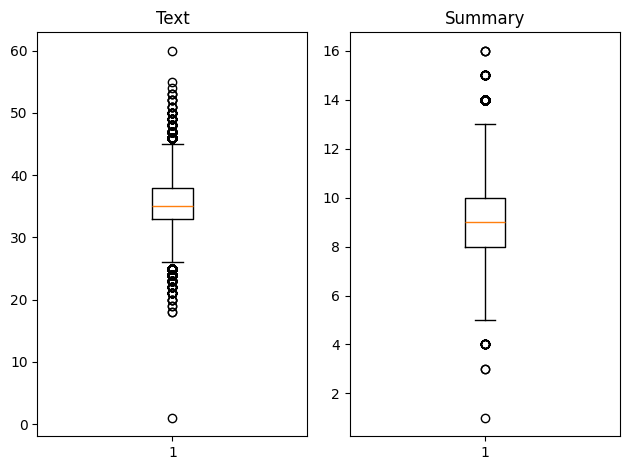

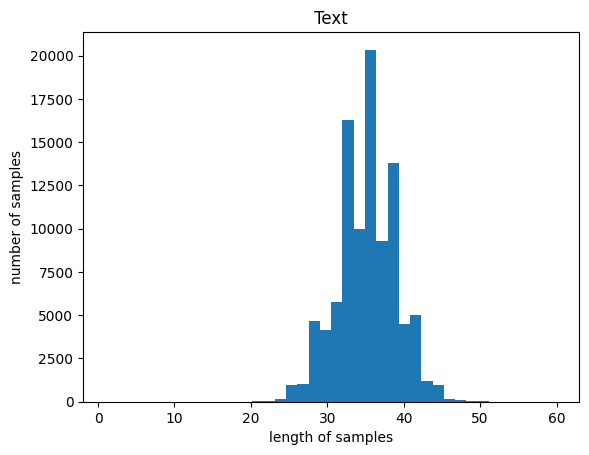

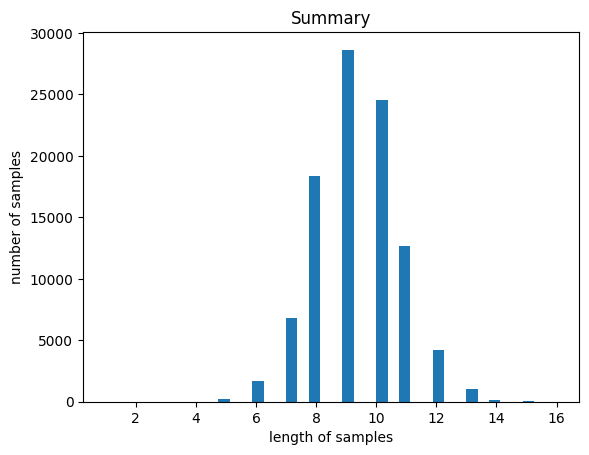

In [6]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in df['text']]
summary_len = [len(s.split()) for s in df['headline']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [7]:
text_max_len = 60
summary_max_len = 16
print('=3')

=3


In [8]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [9]:
below_threshold_len(text_max_len, df['text'])
below_threshold_len(summary_max_len,  df['headline'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


In [10]:
df = df[(df['text'].apply(lambda x: len(x.split()) <= text_max_len)) & 
            (df['headline'].apply(lambda x: len(x.split()) <= summary_max_len))]

In [11]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
df['decoder_input'] = df['headline'].apply(lambda x : 'sostoken '+ x)
df['decoder_target'] = df['headline'].apply(lambda x : x + ' eostoken')
df.head()

,headline,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [12]:
encoder_input = np.array(df['text']) # 인코더의 입력
decoder_input = np.array(df['decoder_input']) # 디코더의 입력
decoder_target = np.array(df['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [13]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[12402 45528 92829 ... 77299 88318 56718]


In [14]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [15]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19680


In [16]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78721
훈련 레이블의 개수 : 78721
테스트 데이터의 개수 : 19680
테스트 레이블의 개수 : 19680


In [17]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [18]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69664
등장 빈도가 6번 이하인 희귀 단어의 수: 47513
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22151
단어 집합에서 희귀 단어의 비율: 68.20308911345889
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4922231427982218


In [19]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [20]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[38, 466, 1636, 130, 41, 293, 6724, 703, 1766, 2833, 151, 15, 372, 65, 1637, 2502, 14257, 392, 313, 271, 1039, 119, 13806, 33, 1276, 139, 4, 29, 24, 1766, 858, 2833, 307, 214, 2861, 1291], [16713, 3336, 679, 211, 92, 231, 3099, 1537, 3336, 520, 4550, 2895, 604, 16713, 665, 4487, 3336, 80, 1891, 23, 147, 119, 10279, 5767, 217, 1515, 10060, 3336, 35, 280, 79, 494, 155, 1456, 10060, 291, 310], [1309, 5768, 2792, 129, 117, 530, 1467, 62, 1, 4990, 1842, 1161, 823, 95, 311, 4, 5541, 402, 823, 2059, 874, 1467, 409, 60, 370, 2792, 117, 1023, 7184, 53, 535, 2, 1091, 39]]


In [21]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [22]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30152
등장 빈도가 5번 이하인 희귀 단어의 수: 19731
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10421
단어 집합에서 희귀 단어의 비율: 65.43844521093128
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.658488860832223


In [23]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3183, 492, 70, 390, 227, 7241, 288, 910], [1, 765, 530, 3184, 5394], [1, 164, 19, 10, 521, 5, 18, 335, 341, 881, 1059], [1, 8, 1573, 1636, 583, 2627, 4, 1573, 1727, 3496], [1, 489, 2475, 942, 5, 489, 117, 16, 333, 1708, 34]]
target
decoder  [[3183, 492, 70, 390, 227, 7241, 288, 910, 2], [765, 530, 3184, 5394, 2], [164, 19, 10, 521, 5, 18, 335, 341, 881, 1059, 2], [8, 1573, 1636, 583, 2627, 4, 1573, 1727, 3496, 2], [489, 2475, 942, 5, 489, 117, 16, 333, 1708, 34, 2]]


In [24]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78720
훈련 레이블의 개수 : 78720
테스트 데이터의 개수 : 19680
테스트 레이블의 개수 : 19680


In [25]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


In [26]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

In [27]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [28]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [29]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [30]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=30)

Epoch 1/30
308/308 [==============================] - 299s 940ms/step - loss: 4.2818 - val_loss: 3.9134
Epoch 2/30
308/308 [==============================] - 297s 964ms/step - loss: 3.7905 - val_loss: 3.6252
Epoch 3/30
308/308 [==============================] - 295s 958ms/step - loss: 3.5427 - val_loss: 3.4429
Epoch 4/30
308/308 [==============================] - 296s 963ms/step - loss: 3.3551 - val_loss: 3.2981
Epoch 5/30
308/308 [==============================] - 296s 959ms/step - loss: 3.2035 - val_loss: 3.1980
Epoch 6/30
308/308 [==============================] - 295s 959ms/step - loss: 3.0779 - val_loss: 3.1161
Epoch 7/30
308/308 [==============================] - 293s 953ms/step - loss: 2.9670 - val_loss: 3.0449
Epoch 8/30
308/308 [==============================] - 290s 942ms/step - loss: 2.8750 - val_loss: 2.9905
Epoch 9/30
308/308 [==============================] - 282s 915ms/step - loss: 2.7930 - val_loss: 2.9452
Epoch 10/30
308/308 [==============================] - 285s 926m

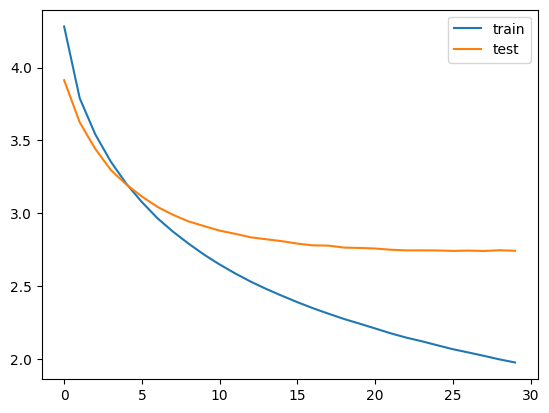

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [32]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [34]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [35]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [36]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [37]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
start_tok = 1
end_tok = 2

def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        # Assuming 'start_tok' and 'end_tok' are the start and end token indices.
        if (i != 0 and i != start_tok and i != end_tok):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [38]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : cbi investigation revealed christian michel alleged middleman agustawestland vvip chopper deal borne foreign travel expenses worth lakh serving retired indian air force officials michel produced delhi court saturday five day cbi remand ended following agency granted four days additional custody 
실제 요약 : michel paid lakh for foreign trips of iaf officials cbi 
1/1 [==============================] - 0s 21ms/step
예측 요약 :  cbi books mea for crore in corruption case


원문 : real estate tycoon hui ka yan topped forbes list china richest first time fortune billion added billion twice gainer led increase share price company china evergrande group followed tencent alibaba jack 
실제 요약 : ka tops forbes china rich list for first time 
1/1 [==============================] - 0s 21ms/step
예측 요약 :  world richest man becomes world richest families


원문 : toronto district school board unanimously adopted motion recognising november hindu heritage month city board third largest north america covers s

In [39]:
import requests
from summa.summarizer import summarize

In [40]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [41]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [42]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [43]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [44]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [45]:
data = {
    'original_text_a': [seq2text(encoder_input_test[0])],
    'abstractive_summary': [decode_sequence(encoder_input_test[0].reshape(1, text_max_len))],
    'original_text_b': [text[:1500]],
    'extractive_summary': [summarize(text, words=30)],
}

df_metric = pd.DataFrame(data)

1/1 [==============================] - 0s 23ms/step


In [46]:
df_metric

,original_text_a,abstractive_summary,original_text_b,extractive_summary
0,year old girl killed eight others hospitalised...,year old girl dies after being beaten by men ...,"The screen is filled with green, cascading cod...","Morpheus, Trinity, Neo, Apoc, Switch, Mouse an..."


In [49]:
# 핵심 키워드 수 구하는 함수
def keyword_analysis(text, summary):
    return len(summary.split())

# 데이터프레임에 적용
df_metric['Abstractive Keyword Count'] = df_metric.apply(lambda x: keyword_analysis(x['original_text_a'], x['abstractive_summary']), axis=1)
df_metric['Extractive Keyword Count'] = df_metric.apply(lambda x: keyword_analysis(x['original_text_b'], x['extractive_summary']), axis=1)

# 추상적, 추출적 키워드 count 보기
df_metric.iloc[:, -2:]

,Abstractive Keyword Count,Extractive Keyword Count
0,11,33


## 회고
- 학습시간이 오래걸려 문법까지 분석하기에는 조금 어려웠다.
- 비교 결과 추출적 요약이 원본에서 keyword를 더 많이 추출했다.
- seq2seq 까지는 대략적으론 이해했으나 attention 메커니즘은 이해가 부족하여 공부를 더 해야 할 것 같다.